# PINNs Approximation including Data Loss

En el notebook 3 se aproximo una ecuación diferencial parcial con la perdidada física y las perdidas en la frontera exclusivamente. En el 2 solo con la perdida en generada por los datos.

En este notebook se combinan ambas perdidas en el entrenamiento para evaluar el cambio en el tiempo requerido y en la precisión alcanzada. Por lo tanto se repetira el procedimiento realizado en los notebooks anteriores, ajustando la celda correspondiente al entrenamiento.

In [9]:
# Import NumPy for numerical operations
import numpy as np

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Import a utility module for additional plotting functions
import utils_plots

# Import the time module to time our training process
import time

In [2]:
# Define a function for the analytical solution of the 1D wave equation
def analytic_sol_func(t, x):
    C = 1
    return sum([(8 / (k**3 * np.pi**3)) * np.sin(k * np.pi * x) * np.cos(C * k * np.pi * t) for k in range(1, 100, 2)])

# Generate training data in NumPy
x_np = np.linspace(0, 1, 100)  # x data (numpy array), shape=(100,)
t_np = np.linspace(0, 1, 100)  # t data (numpy array), shape=(100,)

# Create a grid of x and t values
x_grid, t_grid = np.meshgrid(x_np, t_np) # x and t data (numpy array), shape=(100, 100)

# Calculate u values using the analytical solution function
u_grid = analytic_sol_func(t_grid,x_grid) # u data (numpy array), shape=(100, 100)

In [3]:
# Conversion of the grid data to PyTorch tensors
x = torch.from_numpy(x_grid).float().unsqueeze(-1).requires_grad_(True)
t = torch.from_numpy(t_grid).float().unsqueeze(-1).requires_grad_(True)
u = torch.from_numpy(u_grid).float().unsqueeze(-1)

# Concatenation of x and y to form the input data
input_data = torch.cat((x, t), dim=-1)

#x_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)# sample locations over the problem domain
x_boundary = torch.linspace(0,1,100).view(-1,1).requires_grad_(True)# sample locations over the problem domain
x_boundary_1 = torch.zeros_like(t_boundary)
x_boundary_2 = torch.ones_like(t_boundary)
t_boundary_1 = torch.zeros_like(x_boundary).requires_grad_(True)
input_boundary_x_1 = torch.cat((x_boundary_1, t_boundary), dim=-1)
input_boundary_x_2 = torch.cat((x_boundary_2, t_boundary), dim=-1)
input_boundary_t_1 = torch.cat((x_boundary, t_boundary_1), dim=-1)

In [10]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.output_layer(x)
        return x
    
# Create an instance of the neural network
neural_net = NeuralNetwork()

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net.parameters(), lr=0.01)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

In [11]:
# Initialize a list to store the loss values
loss_values = []
c = 1 # wave speed

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(1001):
    # Predictions for boundary conditions
    prediction_boundary_x_1 = neural_net(input_boundary_x_1)
    prediction_boundary_x_2 = neural_net(input_boundary_x_2)
    prediction_boundary_t_1 = neural_net(input_boundary_t_1)
    prediction_boundary_dudt_1 = neural_net(input_boundary_t_1)

    # Compute derivative of prediction_boundary_dudt_1 with respect to t_boundary_1
    dudt_boundary_dudt_1  = torch.autograd.grad(prediction_boundary_dudt_1, t_boundary_1, torch.ones_like(prediction_boundary_dudt_1), create_graph=True)[0]

    # Compute boundary conditions
    boundary_x_1 = prediction_boundary_x_1 - 0
    boundary_x_2 = prediction_boundary_x_2 - 0
    boundary_t_1 = prediction_boundary_t_1 - x*(1-x)

    # Compute loss for boundary conditions
    loss_boundary = torch.mean(boundary_x_1**2) + torch.mean(boundary_x_2**2) + torch.mean(boundary_t_1**2) + torch.mean(dudt_boundary_dudt_1**2)
    
    # Predictions for physics conditions
    prediction = neural_net(input_data)

    # Compute derivatives of prediction with respect to x and t
    dudx  = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0] # computes du/dx
    dudx2 = torch.autograd.grad(dudx,  x, torch.ones_like(dudx),  create_graph=True)[0] # computes d^2u/dx^2
    dudt  = torch.autograd.grad(prediction, t, torch.ones_like(prediction), create_graph=True)[0] # computes du/dt
    dudt2 = torch.autograd.grad(dudt,  t, torch.ones_like(dudt),  create_graph=True)[0] # computes d^2u/dt^2

    # Compute physics condition
    physics = dudt2 - c**2*dudx2

    # Compute loss for physics condition
    loss_physics = torch.mean(physics**2)

    # Compute data loss
    data_loss = torch.mean((prediction-u)**2)

    # Total loss is the sum of boundary, physics and data loss
    loss = loss_boundary + loss_physics + data_loss

    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    # Print loss every 1000 iterations
    if i % 100 == 0:
        print(f"Iteration {i}: Loss {loss.item()}")
    
    # Clear gradients for next train
    optimizer.zero_grad()

    # Backpropagation, compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Save a summary of the training process to a text file
with open("summaries/4_PINNs_including_data_loss.txt", "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")
    
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")    

Iteration 0: Loss 0.17928527295589447
Iteration 100: Loss 0.02670413628220558
Iteration 200: Loss 0.014671223238110542
Iteration 300: Loss 0.008962550200521946
Iteration 400: Loss 0.0033510050270706415
Iteration 500: Loss 0.005208583083003759
Iteration 600: Loss 0.0009774970822036266
Iteration 700: Loss 0.0005703788483515382
Iteration 800: Loss 0.0003862318117171526
Iteration 900: Loss 0.005147142801433802
Iteration 1000: Loss 0.00024185665824916214
Training time: 17.4228732585907 seconds


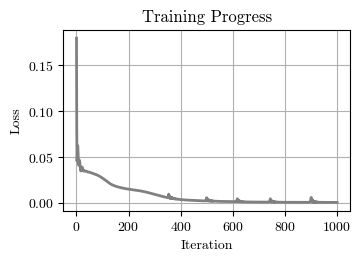

In [12]:
# Create a figure for the plot
fig = plt.figure(figsize=(3.5, 2.5))

# Plot the loss values recorded during training
plt.plot(loss_values, color='gray', linewidth=2)

# Set the labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Set the title for the plot
plt.title('Training Progress')

# Display the grid
plt.grid(True)

# Save the plot as a PNG file in the 'imgs' directory
fig.savefig('imgs/Training_Progress_4_PINNs_including_data_loss.png', format='png')

# Display the plot
plt.show()

In [13]:
# Save the trained model's parameters to a file
torch.save(neural_net.state_dict(), 'models/4_PINNs_including_data_loss.pth')

# Initialize a new instance of the neural network
new_neural_net = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
new_neural_net.load_state_dict(torch.load('models/4_PINNs_including_data_loss.pth'))

# Ensure the new neural network is in evaluation mode
new_neural_net.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

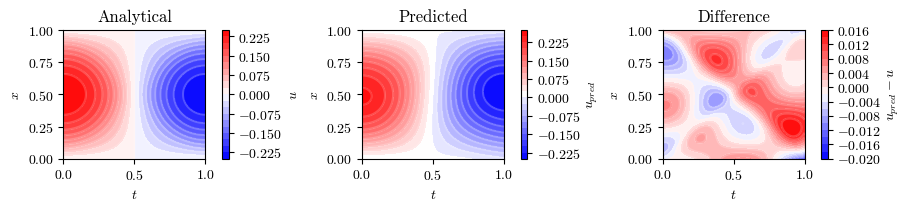

In [14]:
# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data).detach().numpy().reshape(x_grid.shape)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=20, cmap=utils_plots.cmap_)
    ax.set_title(title)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    fig.colorbar(im, ax=ax, label=label)
    ax.contour(x, y, z, levels=20, colors='white', alpha=0.2, linestyles='solid')

# Plot the predicted u values
plot_contour(axs[0], t_grid, x_grid, u_grid, 'Analytical', '$u$')

# Plot the predicted u values
plot_contour(axs[1], t_grid, x_grid, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], t_grid, x_grid, u_pred-u_grid, 'Difference', '$u_{pred}-u$')

# Save the plot as a PDF file in the 'imgs' directory
fig.savefig('imgs/4_Predicted_and_Difference_PINNs_including_data_loss.png', format='png')

# Display the plot
plt.show()